Accuracy: 0.9705882352941176
Cross-Validation Scores: [0.52941176 0.90909091 0.93939394 0.96969697 0.87878788]
Mean Cross-Validation Score: 0.8452762923351159


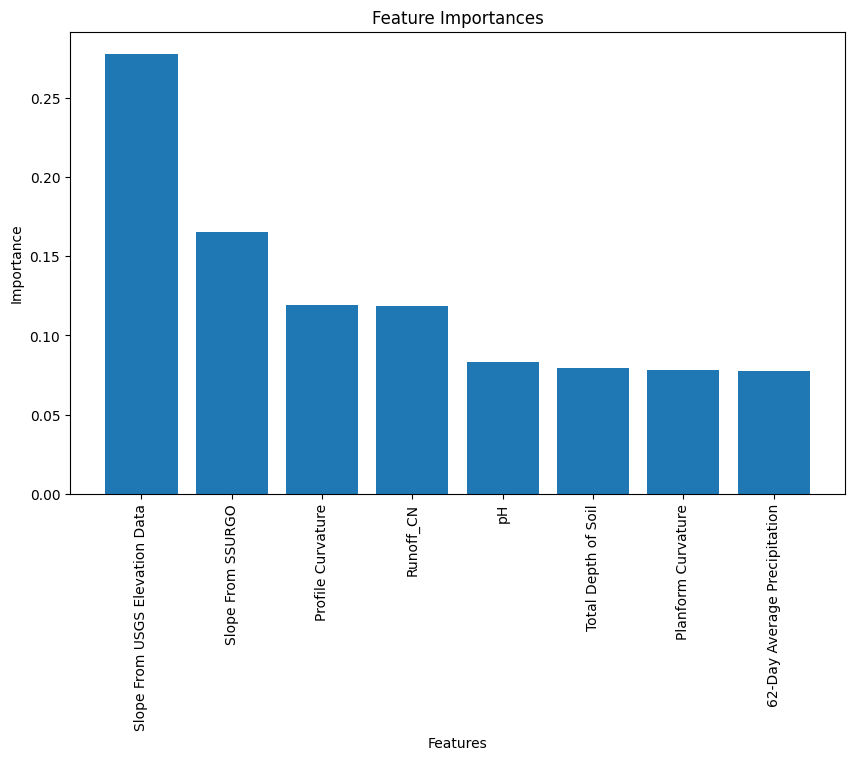

Accuracy: 0.8571428571428571


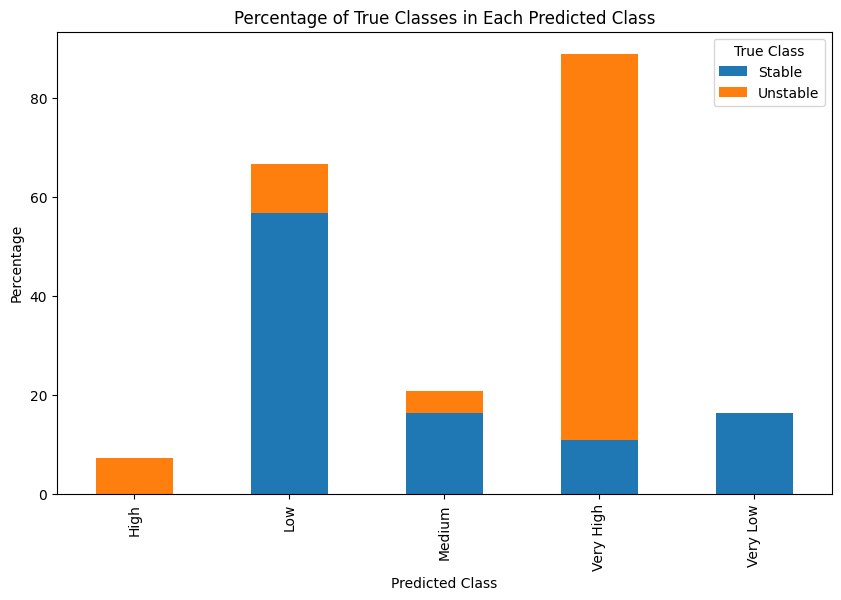

In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Define the tolerance for latitude and longitude differences
tolerance = 0.01  # Adjust this value based on acceptable precision

# Helper function to check if two points are within a certain tolerance
def is_within_tolerance(row, df, tolerance):
    """Checks if a row's latitude and longitude are within a given tolerance."""
    lat_diff = np.abs(df['latitude,N,19,11'] - row['Latitude']) <= tolerance
    lon_diff = np.abs(df['longitude,N,19,11'] - row['Longitude']) <= tolerance
    matched_rows = df[lat_diff & lon_diff]
    if len(matched_rows) > 0:
        return matched_rows.iloc[0]['event_date,D']
    else:
        return np.nan

# Similar helper function for another dataset with different column names
def is_within_tolerance_stable(row, df, tolerance):
    """Checks if a row's latitude and longitude are within a given tolerance for stable data."""
    lat_diff = np.abs(df['latitude'] - row['Latitude']) <= tolerance
    lon_diff = np.abs(df['longitude'] - row['Longitude']) <= tolerance
    matched_rows = df[lat_diff & lon_diff]
    if len(matched_rows) > 0:
        return matched_rows.iloc[0]['date']
    else:
        return np.nan

# Apply the function conditionally based on the 'Stability' column
def get_event_date(row, nasa_df, stable_df, tolerance):
    """Gets event date depending on the stability value (uses NASA data for unstable, Stable data otherwise)."""
    if row['Stability'] == 0:
        return is_within_tolerance(row, nasa_df, tolerance)  # Unstable uses NASA data
    else:
        return is_within_tolerance_stable(row, stable_df, tolerance)  # Stable uses other dataset

# Function to standardize dates into a common format
def standardize_date(date):
    """Attempts to standardize date into MM/DD/YYYY or YYYY-MM-DD formats."""
    try:
        return pd.to_datetime(date, format='%m/%d/%Y')
    except ValueError:
        pass
    try:
        return pd.to_datetime(date, format='%Y-%m-%d')
    except ValueError:
        return pd.NaT  # Return NaT if both formats fail

# Load and preprocess data, selecting relevant columns and balancing the dataset
def load_and_preprocess_data():
    """Loads the input dataset and performs basic preprocessing including column selection and balancing."""
    df = pd.read_csv('Preprocessed_Input_Data.csv')
    runoff_adj_cols = ['Slope From SSURGO', 'Slope From USGS Elevation Data', 'Runoff_CN',
                       'pH', 'Total Depth of Soil', '62-Day Average Precipitation',
                       'Profile Curvature', 'Planform Curvature', 'Stability']

    standard_cols = ['Slope From SSURGO','Slope From USGS Elevation Data', 'Deepest Soil Horizon Layer', 'Organic Matter',
           'pH', 'Bulk Density', '7-Day Maximum Precipitation', '62-Day Average Precipitation', 'Profile Curvature', 'Aspect', 'Stability']

    df_dropped = df[runoff_adj_cols].dropna()

    # Balance dataset by sampling equal rows from stable and unstable classes
    df_unstable = df_dropped[df_dropped['Stability'] == 0]
    df_stable = df_dropped[df_dropped['Stability'] == 1].sample(n=len(df_unstable))

    df_merged_even = pd.concat([df_stable, df_unstable])

    return df_merged_even

# Function to load and preprocess data with event dates based on spatial tolerance
def load_and_preprocess_data_with_event_date():
    """Loads input datasets and applies event date calculation based on spatial proximity and stability."""
    NASA_data = pd.read_csv('NASA_GLC_data.csv', encoding='utf-8')
    Input_Data = pd.read_csv('Preprocessed_Input_Data.csv')
    Stable_Data = pd.read_csv('Stable_Points_Data.csv')

    # Apply event date function
    Input_Data['event_date'] = Input_Data.apply(lambda row: get_event_date(row, NASA_data, Stable_Data, tolerance), axis=1)
    Input_Data['event_date'] = Input_Data['event_date'].apply(standardize_date)

    # Sort data and split based on event date
    Input_Data = Input_Data.sort_values(by='event_date')
    cutoff_date = '2017-01-01'
    train_data = Input_Data[Input_Data['event_date'] < cutoff_date]
    test_data = Input_Data[Input_Data['event_date'] >= cutoff_date]

    # Select relevant columns
    cols = ['Slope From SSURGO', 'Slope From USGS Elevation Data', 'Deepest Soil Horizon Layer',
            'Organic Matter', 'pH', 'Bulk Density', '7-Day Maximum Precipitation',
            '62-Day Average Precipitation', 'Profile Curvature', 'Aspect', 'Stability']


    # Split into features and labels
    X_train = train_data[cols].dropna().drop('Stability', axis=1)
    y_train = train_data[cols].dropna()['Stability']
    X_test = test_data[cols].dropna().drop('Stability', axis=1)
    y_test = test_data[cols].dropna()['Stability']

    return X_train, X_test, y_train, y_test

# Function to train and evaluate a Random Forest model
def train_and_evaluate_model(df_merged_even):
    """Trains and evaluates a Random Forest model using a balanced dataset."""
    X = df_merged_even.drop('Stability', axis=1)
    y = df_merged_even['Stability']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the model
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=5)
    print("Cross-Validation Scores:", cv_scores)
    print("Mean Cross-Validation Score:", cv_scores.mean())

    return model

# Function to plot and save feature importances from a trained model
def plot_feature_importances(model, X, filename):
    """Plots and saves the feature importances from a Random Forest model."""
    importances = model.feature_importances_
    feature_names = X.columns
    sorted_indices = importances.argsort()[::-1]

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Save to Excel
    feature_importance_df.to_excel(filename, index=False)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(X.shape[1]), importances[sorted_indices])
    plt.xticks(range(X.shape[1]), feature_names[sorted_indices], rotation=90)
    plt.title("Feature Importances")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()

# Function to train a Random Forest model and classify samples based on probability thresholds
def train_and_evaluate_with_probability_classes():
    """Trains and evaluates a Random Forest model and assigns classes based on probability thresholds."""
    X_train, X_test, y_train, y_test = load_and_preprocess_data_with_event_date()
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Predict probabilities and classify samples
    y_pred_prob = model.predict_proba(X_test)
    y_pred_5 = [""] * len(y_pred_prob)

    for i in range(len(y_pred_prob)):
        if 0.00 <= y_pred_prob[i][1] < 0.11:
            y_pred_5[i] = "Very Low"
        elif 0.11 <= y_pred_prob[i][1] < 0.49:
            y_pred_5[i] = "Low"
        elif 0.49 <= y_pred_prob[i][1] < 0.67:
            y_pred_5[i] = "Medium"
        elif 0.67 <= y_pred_prob[i][1] < 0.75:
            y_pred_5[i] = "High"
        else:
            y_pred_5[i] = "Very High"

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, model.predict(X_test))
    print("Accuracy:", accuracy)

    return model, y_pred_5, y_test

# Function to create an Excel sheet and plot based on predicted and true classes
def create_excel_and_plot(y_pred_5, y_test):
    """Creates an Excel file and a stacked bar plot showing predicted and true classes."""
    df_results = pd.DataFrame({'Predicted_Class': y_pred_5, 'True_Class': y_test})

    # Create a pivot table for visualization
    pivot_table = pd.pivot_table(df_results, values='True_Class', index='Predicted_Class',
                                 columns='True_Class', aggfunc='size')

    # Calculate percentage for each predicted class
    column_totals = pivot_table.sum(axis=0)
    for true_class in pivot_table.columns:
        for predicted_class in pivot_table.index:
            if pd.notna(pivot_table.loc[predicted_class, true_class]):
                pivot_table.loc[predicted_class, true_class] = (pivot_table.loc[predicted_class, true_class] / column_totals[true_class]) * 100

    # Rename columns to 'Stable' and 'Unstable'
    pivot_table.columns = ['Stable', 'Unstable']

    # Save pivot table to Excel
    pivot_table.to_excel('figure-4_temporal.xlsx')

    # Create a stacked bar plot
    pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title('Percentage of True Classes in Each Predicted Class')
    plt.xlabel('Predicted Class')
    plt.ylabel('Percentage')
    plt.legend(title='True Class')
    plt.show()

if __name__ == "__main__":
    # Load, preprocess, and balance dataset
    df_merged_even = load_and_preprocess_data()

    # Train and evaluate Random Forest model
    model = train_and_evaluate_model(df_merged_even)

    # Plot and save feature importances
    plot_feature_importances(model, df_merged_even.drop('Stability', axis=1), 'figure-5.xlsx')

    # Train and evaluate model with probability classes
    model, y_pred_5, y_test = train_and_evaluate_with_probability_classes()

    # Create Excel sheet and plot with results
    create_excel_and_plot(y_pred_5, y_test)
